In [122]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import timeit
import statistics
import time

In [3]:
from data_utils import synthetic_data

In [8]:
synthetic_data.make_a_group()

([0,
  14,
  233,
  240,
  247,
  254,
  261,
  268,
  275,
  282,
  289,
  296,
  303,
  310,
  317,
  324,
  331,
  338,
  345,
  352,
  359,
  366,
  380,
  387,
  394,
  401,
  408,
  415,
  422,
  429,
  240,
  247,
  254,
  261,
  275,
  282,
  289,
  296,
  303,
  310,
  317,
  324],
 [-326.7892855435035,
  -261.2175253340799,
  -643.9782811379109,
  -643.9782811379109,
  -643.6324006887982,
  -643.9782811379109,
  -643.9782811379109,
  -643.9782811379109,
  -643.9782811379109,
  -643.9782811379109,
  -643.9782811379109,
  -643.9782811379109,
  -643.9782811379109,
  -643.9782811379109,
  -643.9782811379109,
  -643.9782811379109,
  -643.9782811379109,
  -643.9782811379109,
  -643.9782811379109,
  -643.9782811379109,
  -643.9782811379109,
  -643.9782811379109,
  -643.9782811379109,
  -643.9782811379109,
  -515.1826249103287,
  -515.1826249103287,
  -515.1826249103287,
  -515.1826249103287,
  -515.1826249103287,
  -515.1826249103287,
  -538.9534286020474,
  -538.3849731252053,
  -5

### Regular Groups

In [301]:
%timeit make_a_regular_group(period = 7, period_var = 0, num_periods = 10, amount_mean = 100, amount_spread = 50, amount_step_prop = 0.5, amount_outlier_prop = 10)

398 µs ± 3.28 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [10]:
def find_raw_amount_arr(num_periods, dist_version):
    
    if dist_version == 0:
        std =  np.random.uniform(low=0.5, high=3.0, size=None)
        raw_arr =  np.random.normal(0, std, num_periods)
        if np.max(raw_arr) == np.min(raw_arr):
            return raw_arr
        else:
            return (raw_arr - np.min(raw_arr)) / (np.max(raw_arr) - np.min(raw_arr))
        
    elif dist_version == 1:
        raw_arr =   np.random.uniform(low=-1.0, high=1.0, size=num_periods)
        if np.max(raw_arr) == np.min(raw_arr):
            return raw_arr
        else:
            return (raw_arr - np.min(raw_arr)) / (np.max(raw_arr) - np.min(raw_arr))
            
    else:
        return np.zeros(num_periods)
    
raw_amount_arr = find_raw_amount_arr(10, 1)

In [11]:
def find_amount_arr(inp_raw_amount_arr, amount_mean, amount_spread):
    return amount_spread*inp_raw_amount_arr + (amount_mean)

find_amount_arr(raw_amount_arr, -10, 5)

array([ -5.0882353 ,  -7.59623753,  -9.69491163,  -6.0502674 ,
       -10.        ,  -9.92554404,  -5.        ,  -9.66132443,
        -7.97337216,  -7.0081242 ])

In [12]:
def find_steps_array(num_periods):

    #choose the number of steps
    num_steps=np.random.choice(3, 1, p=[0.0, 0.9, 0.1])[0]
    if num_steps ==0:
        return np.zeros(num_periods)
    step_locs_arr = np.sort(np.random.choice(np.arange(1,num_periods), size=num_steps, replace=False, p=None))
    step_arr = np.zeros((num_steps, num_periods))
    for i in range(num_steps):
        step_arr[i,np.arange(step_locs_arr[i], num_periods)] = 2*(np.random.random(1)-0.5)
    step_arr = np.sum(step_arr, axis=0)
    return  step_arr / max(np.max(step_arr), np.abs(np.min(step_arr)))

In [13]:
def find_outlier_array(num_periods):
    num_outliers=np.random.choice(3, 1, p=[0.0, 0.9, 0.1])[0]
    if num_outliers ==0:
        return np.zeros(num_periods)
    outliers_locs_arr = np.sort(np.random.choice(np.arange(1,num_periods), size=num_outliers, replace=False, p=None))
    outliers_arr = np.zeros(num_periods)
    outliers_arr[outliers_locs_arr] = np.random.random(num_outliers)
    return  outliers_arr / max(np.max(outliers_arr), np.abs(np.min(outliers_arr))), outliers_locs_arr

In [14]:
#should we remove from consideration periods that have been selected as outliers etc
def find_skip_period_idxs(num_periods):
    num_skip_periods=np.random.choice(3, 1, p=[0.0, 0.9, 0.1])[0]
    if num_skip_periods ==0:
        return np.zeros(num_periods)
    skip_periods_arr = np.zeros(num_periods)
    skip_periods_idxs = np.random.choice(np.arange(1,num_periods), size=num_skip_periods, replace=False, p=None)
    #skip_periods_arr[skip_periods_idxs] = 1
    return skip_periods_idxs

In [15]:
def make_a_regular_group(period
                         , period_var
                         , num_periods
                         , amount_mean
                         , amount_spread
                         , amount_step_prop
                         , amount_outlier_prop
                         , split_payment_prob = 0
                         , extra_payment_prob = 0
                         , extra_payment_val = 0
                         , initial_payment_prob = 0
                         , initial_payment_val = 0
                         , final_payment_prob = 0
                         , final_payment_val = 0):
    
    #create the template sequence
    raw_amount_arr = find_raw_amount_arr(num_periods, np.random.randint(3, size=1)) 
    amount_arr = find_amount_arr(raw_amount_arr, amount_mean, amount_spread)
    days_arr = np.arange(0, period*num_periods, period)
    
    #step the amounts
    steps_arr = find_steps_array(num_periods)*amount_step_prop*amount_mean
    amount_arr = amount_arr+steps_arr
    
    #create some outliers
    outlier_arr, outlier_loc_arr = find_outlier_array(num_periods)*np.random.uniform(1,amount_outlier_prop, size = 1)
    amount_arr = amount_arr + outlier_arr
    
    #skip some periods
    skip_periods_idxs = find_skip_period_idxs(num_periods)
    amount_arr = np.delete(amount_arr,skip_periods_idxs)
    days_arr = np.delete(days_arr,skip_periods_idxs)
    num_periods = num_periods - len(skip_periods_idxs)
    
    #make sure everything is the same sign
    #flip randomly to be negative
    
    return days_arr, amount_arr
    


In [36]:
make_a_regular_group(period = 7
                         , period_var = 1
                         , num_periods = 10
                         , amount_mean = -100
                         , amount_spread = 10
                         , amount_step_prop = 0.2
                         , amount_outlier_prop = 0.2)

(array([ 0,  7, 21, 28, 35, 42, 49, 56, 63]),
 array([-100., -100., -100., -100., -100., -100., -100.,  -80.,  -80.]))

### Irregular Groups

In [31]:
def make_an_irregular_group(num_trans,
                           mean_amt,
                           mean_days,
                           amt_spread,
                           days_spread,
                           amt_dist_type = '',
                           days_dist_type = ''):
    #sample just from normal to start
    raw_amt_arr = np.random.normal(loc=mean_amt,scale=amt_spread, size=num_trans)
    raw_days_arr = np.random.normal(loc=mean_days,scale=days_spread, size=num_trans)
    
    #remove ones we don't want
    select_mask = np.logical_and(np.sign(raw_amt_arr) == np.sign(mean_amt), raw_days_arr >=0)
    
    amount_arr = raw_amt_arr[select_mask]
    days_arr = raw_days_arr[select_mask].astype(int)
    
    
    return days_arr, amount_arr
    
    

In [35]:
make_an_irregular_group(num_trans = 10,
                           mean_amt = -100,
                           mean_days = 22,
                           amt_spread = 100,
                           days_spread = 20)

(array([16, 46, 25, 65,  7, 23, 22]),
 array([-184.25209685, -127.91338193, -105.7548114 , -254.45490229,
         -90.78487884,  -96.48374586, -139.22199217]))

### Create groups

In [143]:
def make_a_group():
    #select number of regualr groups
    num_reg_groups = np.random.randint(4,size=1)[0]
    #print(num_reg_groups)
    #select range of reg group sizes
    reg_group_sizes = np.random.randint(3,30, size=num_reg_groups)
    #select amount mean of reg group sizes
    reg_group_amt_means = np.random.uniform(-1000,-100, size=num_reg_groups)
    #select reg group offsets
    reg_group_offsets = np.random.randint(0,300, size=num_reg_groups)
    
    
    day_list = []
    amt_list = []
    group_id_list = []
    
    for g in range(num_reg_groups):
        #print(g)
        
        d_arr, a_arr = make_a_regular_group(period = 7
                             , period_var = 1
                             , num_periods = reg_group_sizes[g]
                             , amount_mean = reg_group_amt_means[g]
                             , amount_spread = 10
                             , amount_step_prop = 0.2
                             , amount_outlier_prop = 0.2)
        
        if g == 0:
            reg_group_offset = 0
        else:
            reg_group_offset = reg_group_offsets[g]
        
        day_list = day_list + list(d_arr+reg_group_offset)
        amt_list = amt_list + list(a_arr)
        group_id_list = group_id_list + [g]*len(d_arr)
        
        
    #add some irregs
    
    if len(day_list) == 0 or np.random.uniform(0,1) <= 0.5:
    
        irreg_group_sizes = np.random.randint(3,30)
        irreg_group_amt_mean = np.random.uniform(-1000,-100)
        if len(day_list) == 0:
            irreg_group_days_mean = np.random.randint(0,300)
            irreg_group_id = 0
        else:
            irreg_group_days_mean = statistics.mean(day_list)
            irreg_group_id = max(group_id_list)+1


        d_arr, a_arr = make_an_irregular_group(num_trans = irreg_group_sizes,
                               mean_amt = irreg_group_amt_mean,
                               mean_days = irreg_group_days_mean,
                               amt_spread = 100,
                               days_spread = 25,
                               amt_dist_type = '',
                               days_dist_type = '')
        
        day_list = day_list + list(d_arr)
        amt_list = amt_list + list(a_arr)
        group_id_list = group_id_list + [irreg_group_id]*len(d_arr)
    
    
    return day_list, amt_list, group_id_list
    

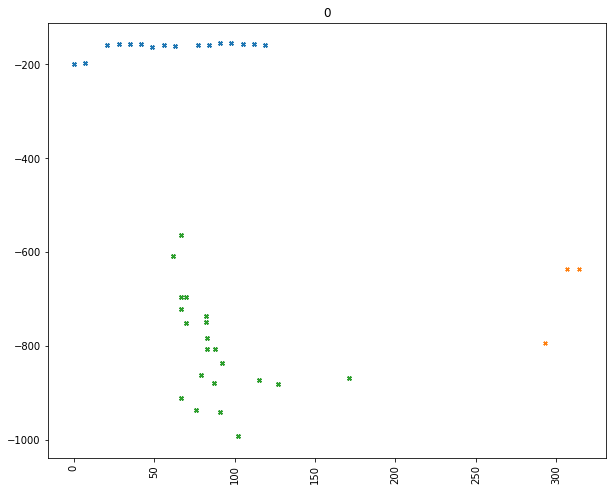

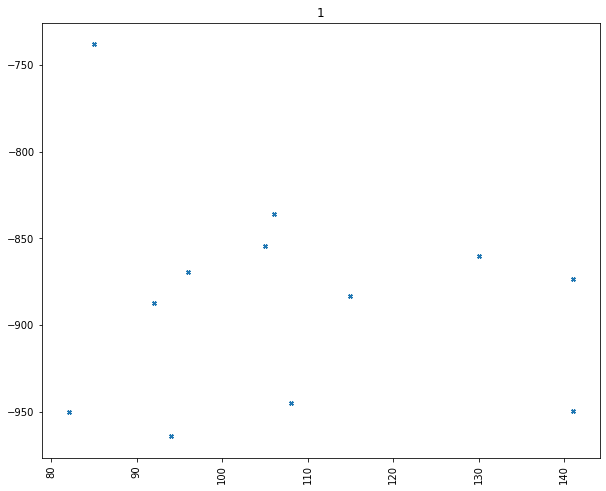

In [161]:
colour_list = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

for i in range(2):
    d_lst, a_lst, g_lst = make_a_group()
    
    d_arr = np.array(d_lst)
    a_arr = np.array(a_lst)
    g_arr = np.array(g_lst)    
    
    fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(10,8), sharex=True)
    for g in g_lst:
        mask = (g_arr == g)
        
        ax1.scatter(d_arr[mask], a_arr[mask], s=10, c=colour_list[g%10], marker='x')
        ax1.set_title(str(i))
        #ax1.legend(loc="upper right")
    
    for ax1 in fig.axes:
        matplotlib.pyplot.sca(ax1)
        plt.xticks(rotation=90)
        #plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
    
    plt.show


In [ ]:



colour_list = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']


for mg in list(set(labels_data_df['num of new_groups'].values)):
    for lg in list(set(labels_data_df['num of old_groups'].values)):
        
        if (mg == 1 and lg == 1):
            continue
            

        if dict_out[(mg,lg)] == []:
            continue
            
        else:
            folder_path = r'C:\Users\andy.knapper\Documents\OW\Categorisation\Grouping logic\Pause Process examples\New combination logic\Old_group_size_'+str(lg)+'__New_group_size_'+str(mg)
            if not os.path.exists(folder_path):
                os.makedirs(folder_path)
            
            for a_g in dict_out[(mg,lg)]:
                a = a_g[0]
                gs = a_g[1]
                for g in gs:
                
                    this_merch_desc_group_df = labels_data_df.loc[(labels_data_df['AccountId']==a) & (labels_data_df['comb_merch_desc_group']==g)]
                    
                    !!!!!!!!!!!!!!!!!!
                    #if the number of old groups, new groups and combinations are all the same then continue
                    
                    num_of_new_groups = np.max(this_merch_desc_group_df['num of new_groups'].values)
                    num_of_old_groups = np.max(this_merch_desc_group_df['num of old_groups'].values)
                    num_of_old_new_combs = np.max(this_merch_desc_group_df['num of old new combs'].values)
                    
                    if num_of_new_groups == num_of_old_groups and num_of_old_groups == num_of_old_new_combs:
                        continue
                    
                    num_comb_merch_desc_group = len(list(this_merch_desc_group_df.comb_merch_desc_group.values))
                    old_groups_size = np.max(this_merch_desc_group_df.old_groups_size.values)
                    new_groups_size = np.max(this_merch_desc_group_df.new_groups_size.values)   
                    
                    if num_comb_merch_desc_group >= 4 :
                    
                        amt_arr = this_merch_desc_group_df.Amount.values
                        date_arr = this_merch_desc_group_df.TransactionDate.values

                        model_groups_arr = this_merch_desc_group_df['new_groups'].values
                        labels_groups_arr = this_merch_desc_group_df['old_groups'].values

                        group_diff_metric = round(np.max(this_merch_desc_group_df['group_diff_metric'].values),2)
                        account_label = np.max(this_merch_desc_group_df['account_label'].values)

                        #create the chart                
                        fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,8), sharex=True)

                        for i in np.unique(model_groups_arr):
                            #print('i: ', i)

                            mask = model_groups_arr == i
                            if i == -1:
                                marker = 'x'
                                s = 20
                            else:
                                marker = 's'
                                s = 10
                            #print('ex_num_date_arr[mask]:', ex_num_date_arr[mask])
                            #print('ex_num_amt_arr[mask]:', ex_num_amt_arr[mask])

                            ax1.scatter(date_arr[mask], amt_arr[mask], s=s, c=colour_list[i%10], marker=marker, label=i)
                            ax1.set_title('Model_groups_' + str(account_label) + '_'+str(g))

                            ax1.legend(loc="upper right")

                        for ax1 in fig.axes:
                            matplotlib.pyplot.sca(ax1)
                            plt.xticks(rotation=90)
                            plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)

                        for i in np.unique(labels_groups_arr):
                            #print('i: ', i)

                            mask = labels_groups_arr == i
                            if i == -1:
                                marker = 'x'
                                s = 20
                            else:
                                marker = 's'
                                s = 10
                            #print('ex_num_date_arr[mask]:', ex_num_date_arr[mask])
                            #print('ex_num_amt_arr[mask]:', ex_num_amt_arr[mask])

                            ax2.scatter(date_arr[mask], amt_arr[mask], s=s, c=colour_list[i%10], marker=marker, label=i)
                            ax2.set_title('label_groups_' + str(account_label) + '_'+str(g))

                            ax2.legend(loc="upper right")

                        for ax2 in fig.axes:
                            matplotlib.pyplot.sca(ax2)
                            plt.xticks(rotation=90)
                            plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)


                        plt.plot
                        plt.savefig(folder_path +'\\'+str(group_diff_metric) + '_' + str(account_label) + '_'+str(g)+'.png', bbox_inches='tight')        
                        plt.close(fig)

                        #place into the folder lg_mg


                        #name the file group_diff_metric_a_g


### Set up the model

In [1]:
import torch

In [2]:
torch.__version__

'1.3.0'

In [3]:
import torch_geometric

In [4]:
import torch_scatter

In [5]:
import torch
from torch.nn import Sequential as Seq, Linear as Lin, ReLU
from torch_geometric.nn import MessagePassing

class EdgeConv(MessagePassing):
    def __init__(self, F_in, F_out):
        super(EdgeConv, self).__init__(aggr='max')  # "Max" aggregation.
        self.mlp = Seq(Lin(2 * F_in, F_out), ReLU(), Lin(F_out, F_out))

    def forward(self, x, edge_index):
        # x has shape [N, F_in]
        # edge_index has shape [2, E]
        return self.propagate(edge_index, x=x)  # shape [N, F_out]

    def message(self, x_i, x_j):
        # x_i has shape [E, F_in]
        # x_j has shape [E, F_in]
        edge_features = torch.cat([x_i, x_j - x_i], dim=1)  # shape [E, 2 * F_in]
        return self.mlp(edge_features)  # shape [E, F_out]